In [81]:
# ALL IMPORTS
from PIL import Image
import numpy as np
import moviepy.video.io.ImageSequenceClip
import cv2, os
import numpy as np
import torch

In [82]:
def load_frame(path):
  im = Image.open(path)
  return np.array(im)

# Data Loading & Pre-Processing

In [3]:
!wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
!tar -xzf UCSD_Anomaly_Dataset.tar.gz
!rm -rf Train
!rm -rf Test
!mkdir Train
!mkdir Test
!mv UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train .
!mv UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test .
!rm -rf UCSD_Anomaly_Dataset.v1p2

--2023-05-03 22:36:58--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  21.5MB/s    in 36s     

2023-05-03 22:37:35 (19.4 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [4]:
def load_label_dict():
  arr = []
  with open('Test/UCSDped2.m') as f:
    for line in f:
      if 'gt_frame' in line:
        rng = line.split('[')[1][:-3]
        arr.append([int(s) for s in rng.split(':')])
  d = {i: arr[i] for i in range(12)}
  return d

def load_video_and_labels(test=False):
  root_dir = 'Test' if test else 'Train'
  d = load_label_dict()
  video_folders = [f for f in os.listdir(root_dir) if root_dir in f and 'gt' not in f]
  video_folders.sort()
  all_data = []
  for index, video_folder in enumerate(video_folders):
    frames = [f for f in os.listdir(root_dir + '/' + video_folder) if 'tif' in f]
    all_frame_matrices = [load_frame(root_dir + '/' + video_folder + '/' + frame) for frame in frames]
    num_frames = len(frames)
    if test:
      min_index, max_index = d[index]
      y_true = np.concatenate((np.zeros(min_index - 1), np.ones(max_index - min_index + 1), np.zeros(num_frames - max_index)))
      all_data.append((np.array(all_frame_matrices), y_true))
    else:
      all_data.append(np.array(all_frame_matrices))
  return all_data
result = load_video_and_labels(test=True)

In [5]:
test_videos = load_video_and_labels(test=True)
train_videos = load_video_and_labels(test=False)

In [6]:
test_videos[0][0].shape, test_videos[0][1].shape, train_videos[0].shape

((180, 240, 360), (180,), (120, 240, 360))

In [7]:
!mkdir videos

In [ ]:
def images_to_mp4(path, vid_name):
  image_files = [os.path.join(path,img) for img in os.listdir(path) if img.endswith(".tif")]
  jpeg_files = []
  for f in image_files:
    read = cv2.imread(f)
    outfile = f.split('.')[0] + '.jpg'
    jpeg_files.append(outfile)
    cv2.imwrite(outfile, read ,[int(cv2.IMWRITE_JPEG_QUALITY), 200])
  jpeg_files.sort()
  clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(jpeg_files, fps=10)
  clip.write_videofile(vid_name + '.mp4')

for i in range(12):
  images_to_mp4('Test/Test' + ('00' + str(i + 1) if i + 1 < 10 else '0' + str(i + 1)), 'videos/Test' + str(i + 1))

for i in range(16):
  images_to_mp4('Train/Train' + ('00' + str(i + 1) if i + 1 < 10 else '0' + str(i + 1)), 'videos/Train' + str(i + 1))


# Loading Bounding Boxes

In [9]:
!pip install ultralytics &> /dev/null

In [10]:
from ultralytics import YOLO

bounding_box_model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 70.1MB/s]


In [11]:
result = bounding_box_model('Train/Train001/001.tif')[0].boxes.xywh
result = result.detach().cpu().numpy()
result


image 1/1 /content/Train/Train001/001.tif: 448x640 19 persons, 60.8ms
Speed: 15.5ms preprocess, 60.8ms inference, 35.4ms postprocess per image at shape (1, 3, 640, 640)


array([[     46.687,      197.87,       13.01,      38.264],
       [     169.73,       142.6,      18.295,      30.759],
       [     292.44,      135.29,      18.152,      37.686],
       [      49.02,      140.84,       12.23,      29.661],
       [     116.06,      140.73,      15.072,       30.18],
       [     225.84,      118.97,      10.316,      28.568],
       [     354.32,       115.8,       11.07,       27.11],
       [     88.955,      157.58,      14.835,      35.762],
       [     150.78,      123.01,      20.685,      28.714],
       [     198.23,      123.09,      16.686,      33.311],
       [     248.59,      133.41,      16.092,      28.761],
       [     182.31,      121.85,      16.357,      29.211],
       [     328.43,      113.99,      22.555,      35.228],
       [     99.396,      150.43,      14.199,      33.546],
       [     15.974,      136.67,      16.635,      30.929],
       [      32.76,       110.7,      11.066,       29.33],
       [     68.219,    

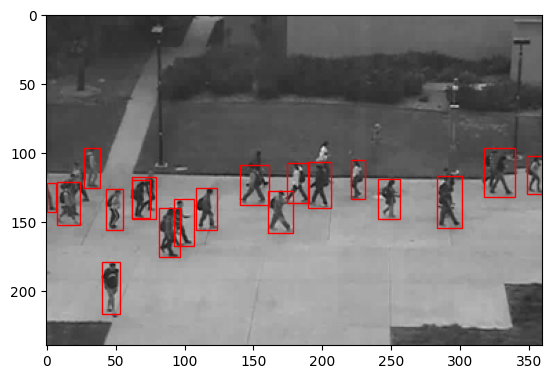

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('Train/Train001/001.jpg')
fig, ax = plt.subplots()
ax.imshow(im)
for row in result:
  x, y, w, h = tuple(row.tolist())
  rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
plt.show()

In [53]:
def yolo_result_to_trajectories(result):
  num_frames = len(result)
  xywh = []
  for i in range(num_frames):
    xywh.append(result[i].boxes.xywh.detach().cpu().numpy()[np.argwhere(result[i].boxes.conf.detach().cpu().numpy() >= 0.5)])

  trajectories = {}

  for i in range(xywh[0].shape[0]):
    trajectories[i] = [(0, i)]

  for t in range(1, num_frames):
    labeled = []
    for k in trajectories.keys():
      traj = trajectories[k]
      traj_last = traj[-1]
      if traj_last[0] == t - 1:
        distances = np.sum((xywh[t] - xywh[t - 1][traj_last[1]])**2, axis=2).flatten()
        closest_index = np.argwhere(distances < 50).flatten().tolist()
        if len(closest_index) > 0:
          closest_index = closest_index[0]
          traj.append((t, closest_index))
          labeled.append(closest_index)
    for i in range(xywh[t].shape[0]):
      if i not in labeled:
        trajectories[len(trajectories.keys())] = [(t, i)]
  return trajectories, xywh

def padded_num(num):
  return '00' + str(num) if num < 10 else ('0' + str(num) if num < 100 else str(num))

def video_to_cropped_resized_trajs(video_index, is_test):
  # we assume 0-index
  video_index = video_index + 1 
  result = list(bounding_box_model('videos/' + ('Test' if is_test else 'Train') + str(video_index) + '.mp4', verbose=False, stream=True))
  # print(list(result))
  trajs, xywh = yolo_result_to_trajectories(result)
  filtered_trajs = [trajs[k] for k in [k for k in trajs.keys() if len(trajs[k]) > 10]]
  for i in range(len(filtered_trajs)):
    traj = filtered_trajs[i]
    seq = 0
    for t, index in traj:
      first_part = 'Test/Test' if is_test else 'Train/Train'
      second_part = padded_num(video_index) + '/'
      im = Image.open(first_part + second_part + padded_num(t + 1) + '.jpg')
      coords = xywh[t][index][0]
      left, top = coords[0], coords[1]
      w, h = coords[2], coords[3]
      im1 = im.crop((left - w/2, top - h/2, left + w/2, top + h/2))
      im1 = im1.resize((64, 64))
      seq_number = t if is_test else seq
      im1.save('Trajectories/' + ('Test' if is_test else 'Train') + str(video_index) + '/Traj' + padded_num(i) + '_' + padded_num(seq_number) + '.png')
      seq += 1


In [54]:
!rm -rf Trajectories

def make_folder_safe(path):
  if not os.path.exists(path):
    os.makedirs(path)

make_folder_safe('Trajectories')

for i in range(1, 17):
  make_folder_safe('Trajectories/Train' + str(i))

for i in range(1, 13):
  make_folder_safe('Trajectories/Test' + str(i))

In [55]:
# for i in range(16):
#   print('Train', i)
#   video_to_cropped_resized_trajs(i, False)

for i in range(12):
  print('Test', i)
  video_to_cropped_resized_trajs(i, True)


Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Test 10
Test 11


In [ ]:
!zip -r Test.zip Trajectories

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
!mkdir Trajectories
%cd '/content/drive/MyDrive/School/Spring 2023/DL Project'
!unzip Train.zip -d /content
#!unzip Test.zip -d /content
%cd '/content'

# Overall 3D CNN

In [84]:
import torch
from torch.nn import Module, Conv3d, MaxPool3d, BatchNorm3d, Conv2d, MaxPool2d, Linear, Softmax, ReLU
import torch.nn.functional as F

class CustomPad(Module):
  def __init__(self, device='cpu'):
    super(CustomPad, self).__init__()
    self.device = device

  def forward(self, X):
    shape1, shape2 = list(X.shape), list(X.shape)
    time_dim = X.shape[2]
    shape1[2] = time_dim // 2
    shape2[2] = time_dim - time_dim // 2
    pad1, pad2 = torch.zeros(shape1).to(self.device), torch.zeros(shape2).to(self.device)
    return torch.cat((pad1, X, pad2), dim=2).to(self.device)

class CNN3D(Module):
  def __init__(self, device = 'cpu', deep=False, wide=False, weights=None):
    super(CNN3D, self).__init__()
    self.deep = deep
    self.wide = wide
    self.conv_sizes = np.array([16, 16, 32, 32, 32, 32]) if deep else np.array([16, 32, 32])
    self.conv_sizes *= 1 + int(self.wide)
    self.layers = []
    shallow_indices, deep_indices = [0, 1, 2], [1, 3, 5, 7]
    for i in range(len(self.conv_sizes)):
      in_channels = 3 if i == 0 else self.conv_sizes[i - 1]
      out_channels = self.conv_sizes[i]
      self.layers.append(Conv3d(in_channels, out_channels, kernel_size=(3, 3, 3), padding='same').to(device))
      self.layers.append(BatchNorm3d(out_channels).to(device))
      if weights is not None and 'layer_conv' + str(i) in weights.keys():
        self.layers[-2].weights.data = weights['layer_conv' + str(i)]
        self.layers[-1].weights.data = weights['layer_batch' + str(i)]
      self.layers.append(ReLU().to(device))
      if (not deep and i in shallow_indices) or (deep and i in deep_indices):
        self.layers.append(CustomPad(device=device))
        self.layers.append(MaxPool3d(kernel_size=(1, 2, 2), stride=2).to(device))
    self.final_2d = Conv2d(32 * (1 + int(wide)), 32, kernel_size=(2, 2), padding='same').to(device)
    if weights is not None:
      self.final_2d.weights.data = weights['final_conv']
    self.max_pool2d = MaxPool2d(kernel_size=(2,2), stride=2).to(device)
    # 3 max pools if shallow, 4 if deep
    # then 1 more max pool from 2d layer
    # so final spacial is 4x4 if shallow, 2x2 if deep
    # and we have 32 filters
    self.final_linear = Linear(32*(2**(4-2*int(self.deep))), 2).to(device)
    if weights is not None:
      self.final_linear.weights.data = weights['final_linear_weight']
      self.final_linear.bias.data = weights['final_linear_bias']
    self.final_softmax = Softmax(dim=-1).to(device)

  def forward(self, X):
    out = X
    # print(out.shape)
    for layer in self.layers:
      # print(layer)
      out = layer(out)
      # print(out.shape)
    out = torch.max(out, 2)[0] # take max over time dimension
    # print(out.shape)
    out = self.final_2d(out)
    # print(out.shape)
    out = self.max_pool2d(out)
    # print(out.shape)
    out = torch.flatten(out, start_dim=1)
    # print(out.shape)
    out = self.final_linear(out)
    # print(out.shape)
    out = self.final_softmax(out)
    # print(out.shape)
    return out
# Input looks like (N, C, T, W, H)
# After 3D: (N, C, W, H)
# After flattening: (N, C*W*H)

# Preparing Model Input

In [85]:
def get_trajectory_frames(path, num_trajectories=6, is_test=False):
  files = os.listdir(path)
  trajectories = {}
  for f in files:
    if len(f) == 15:
      id, seq = f[4:7], f[8:11]
      if id not in trajectories.keys():
        trajectories[id] = [seq]
      else:
        trajectories[id].append(seq)
  for id in trajectories.keys():
    trajectories[id].sort()
    frames = np.array([load_frame(path + '/Traj' + id + '_' + seq + '.png') for seq in trajectories[id]])
    if is_test:
      trajectories[id] = [np.swapaxes(np.swapaxes(np.swapaxes(frames, 1, 3), 2, 3), 0, 1), trajectories[id]]
    else:
      trajectories[id] = np.swapaxes(np.swapaxes(np.swapaxes(frames, 1, 3), 2, 3), 0, 1)
  ids = list(trajectories.keys())
  if is_test:
    ids.sort(reverse=True, key=lambda k:trajectories[k][0].shape[1])
  else:
    ids.sort(reverse=True, key=lambda k:trajectories[k].shape[1])
  cutoff = min(len(ids), num_trajectories)
  trajectories = {k: trajectories[k] for k in ids[:cutoff]} # just take the `num_trajectories` longest trajectories
  return trajectories

In [86]:
def generate_random_indices(index, num_frames, time_to_center=2):
  # end_index is EXCLUSIVE
  indices = []
  if index > 0 and index <= time_to_center:
    indices = list(range(index))
  elif index > 0:
    lower_index = 0 if index <= time_to_center*4 else index - time_to_center*4
    indices = np.random.choice(np.arange(lower_index, index), size=time_to_center, replace=False).tolist()
  indices.append(index)
  if index >= num_frames - 1 - time_to_center:
    indices += list(range(index + 1, num_frames))
  else:
    upper_index = num_frames if index > num_frames - 1 - 4*time_to_center else index + 4*time_to_center
    indices += np.random.choice(np.arange(index + 1, upper_index), size=time_to_center, replace=False).tolist()
  indices.sort()
  return indices

def get_normal_window(trajectory, index, time_to_center=2):
  num_frames = trajectory.shape[1]
  if i < time_to_center:
    normal_indices = range(time_to_center + 1 + i)
  elif i < num_frames - time_to_center:
    normal_indices = range(i - time_to_center, i+time_to_center + 1)
  else:
    normal_indices = range(i - time_to_center, num_frames)
  return trajectory[None, :, normal_indices, :, :]

def generate_input_windows(trajectory, time_to_center=2):
  tail_ends = []
  bulk_test_cases = []
  num_frames = trajectory.shape[1]
  for i in range(time_to_center):
    normal_indices = range(time_to_center + 1 + i)
    random_indices = generate_random_indices(i, num_frames, time_to_center=time_to_center)
    label = int(not np.all(np.array(normal_indices) == np.array(random_indices)))
    tail_ends.append((trajectory[None, :, normal_indices, :, :], trajectory[None, :, random_indices, :, :], 0, label))
  for i in range(time_to_center, num_frames - time_to_center):
    normal_indices = range(i - time_to_center, i+time_to_center + 1)
    random_indices = generate_random_indices(i, num_frames, time_to_center=time_to_center)
    label = int(not np.all(np.array(normal_indices) == np.array(random_indices)))
    bulk_test_cases.append((trajectory[None, :, normal_indices, :, :], trajectory[None, :, random_indices, :, :], 0, label))
  for i in range(num_frames - time_to_center, num_frames):
    normal_indices = range(i - time_to_center, num_frames)
    random_indices = generate_random_indices(i, num_frames, time_to_center=time_to_center)
    label = int(not np.all(np.array(normal_indices) == np.array(random_indices)))
    tail_ends.append((trajectory[None, :, normal_indices, :, :], trajectory[None, :, random_indices, :, :], 0, label))
  return tail_ends, bulk_test_cases

# CNN Training

In [87]:
import random

def set_seeds(seed=25):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

def get_all_training_data(lower_index=1, upper_index=16, sample_size=6):
  all_tail_ends_3 = []
  all_tail_ends_4 = []
  all_bulk_matrices = []
  labels_3 = []
  labels_4 = []
  bulk_labels = []
  for i in range(lower_index, upper_index + 1):
    trajectory_dict = get_trajectory_frames('Trajectories/Train' + str(i))
    for k in trajectory_dict.keys():
      tail_ends, bulk_test_cases = generate_input_windows(trajectory_dict[k])
      for idx in [0, -1]:
        all_tail_ends_3.append(tail_ends[idx][0])
        all_tail_ends_3.append(tail_ends[idx][1])
        labels_3.append(tail_ends[idx][2])
        labels_3.append(tail_ends[idx][3])
      for idx in [1, -2]:
        all_tail_ends_4.append(tail_ends[idx][0])
        all_tail_ends_4.append(tail_ends[idx][1])
        labels_4.append(tail_ends[idx][2])
        labels_4.append(tail_ends[idx][3])
      all_bulk_matrices.append(torch.cat(tuple([torch.from_numpy(tup[0]).float() for tup in bulk_test_cases]), 0))
      all_bulk_matrices.append(torch.cat(tuple([torch.from_numpy(tup[1]).float() for tup in bulk_test_cases]), 0))
      bulk_labels.append([tup[2] for tup in bulk_test_cases])
      bulk_labels.append([tup[3] for tup in bulk_test_cases])
  all_tail_ends_3 = torch.cat(tuple([torch.from_numpy(mat).float() for mat in all_tail_ends_3]), 0)
  all_tail_ends_4 = torch.cat(tuple([torch.from_numpy(mat).float() for mat in all_tail_ends_4]), 0)
  if len(all_bulk_matrices) > sample_size:
    indices = np.random.choice(len(all_bulk_matrices), size=sample_size, replace=False)
    all_bulk_matrices = [all_bulk_matrices[i] for i in indices]
    bulk_labels = [bulk_labels[i] for i in indices]
  all_bulk_matrices = torch.cat(tuple(all_bulk_matrices), 0)
  labels_3 = torch.from_numpy(np.array(labels_3))
  labels_4 = torch.from_numpy(np.array(labels_4))
  bulk_labels = torch.cat(tuple([torch.from_numpy(np.array(arr)).long() for arr in bulk_labels]), 0)
  
  return all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels

def get_batches(size, batch_size):
  ranges = []
  for i in range(0, size, batch_size):
    end_index = size if i + batch_size > size else i + batch_size
    ranges.append(list(range(i, end_index)))
  return ranges

def run_validation_batches(model, criterion, X, y_true, batch_size):
  all_out_probs = []
  all_true_values = []
  all_loss = 0
  batches = get_batches(X.shape[0], batch_size)
  for indices in batches:
    X_batch = X[indices, :, :, :, :]
    y_batch = y_true[indices]
    out_probs = model(X_batch)
    # loss = criterion(out_probs, y_batch)
    # all_loss += loss.item()
    all_out_probs.append(out_probs)
    all_true_values.append(y_batch)
  return all_loss, all_out_probs, all_true_values

def optimize_batches(optimizer, model, criterion, X, y_true, batch_size, val=False):
  if val:
    return run_validation_batches(model, criterion, X, y_true, batch_size)
  all_out_probs = []
  all_true_values = []
  all_loss = 0
  batches = get_batches(X.shape[0], batch_size)
  for indices in batches:
    X_batch = X[indices, :, :, :, :]
    y_batch = y_true[indices]
    optimizer.zero_grad()
    out_probs = model(X_batch)
    loss = criterion(out_probs, y_batch)
    loss.backward()
    optimizer.step()
    all_loss += loss.item()
    all_out_probs.append(out_probs)
    all_true_values.append(y_batch)
  return all_loss, all_out_probs, all_true_values

def accuracy(all_out_probs, all_true_values):
  num_correct = 0
  total_points = 0
  for i in range(len(all_out_probs)):
    num_correct += torch.sum(torch.argmax(all_out_probs[i], dim=1) == all_true_values[i])
    total_points += all_out_probs[i].shape[0]
  return num_correct / total_points

def train(model, training_range, validation_range, optimizer, criterion, num_epochs, batch_size=256, device='cpu'):
  set_seeds()
  model.train()
  print('batch_size', batch_size)
  all_tensors = []
  for index in range(training_range[0], training_range[1] + 1):
    all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels = get_all_training_data(index, index)
    data = [all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels]
    all_tensors.append(tuple([tensor.to(device) for tensor in data]))
  all_val_tensors = []
  for index in range(validation_range[0], validation_range[1] + 1):
    all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels = get_all_training_data(index, index)
    data = [all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels]
    all_val_tensors.append(tuple([tensor.to(device) for tensor in data]))
  for epoch in range(num_epochs):
    for (is_val, all_tensors_arr, rng) in [(False, all_tensors, training_range), (True, all_val_tensors, validation_range)]:
      totalLoss = 0.0
      all_out_probs = []
      all_true_values = []
      for all_tail_ends_3, all_tail_ends_4, all_bulk_matrices, labels_3, labels_4, bulk_labels in all_tensors_arr:
        for X, y_true in [(all_tail_ends_3, labels_3), (all_tail_ends_4, labels_4), (all_bulk_matrices, bulk_labels)]:
          loss, out_probs, true_values = optimize_batches(optimizer, model, criterion, X.to(device), y_true.to(device), batch_size, val=is_val)
          totalLoss += loss
          all_out_probs += out_probs
          all_true_values += true_values
      print(('Val ' if is_val else 'Train ') + 'Loss for Epoch %d:' % epoch, totalLoss)
      print(('Val ' if is_val else 'Train ') + 'Accuracy for Epoch %d:' % epoch, accuracy(all_out_probs, all_true_values).item())
      torch.cuda.empty_cache()
  return model

In [88]:
device = 'cuda'
model = CNN3D(device = device).to(device)
training_range = (1, 12)
validation_range = (15, 16)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 100

model = train(model, training_range, validation_range, optimizer, criterion, num_epochs, batch_size=256, device=device)

batch_size 256
Train Loss for Epoch 0: 33.55926665663719
Train Accuracy for Epoch 0: 0.5461379289627075
Val Loss for Epoch 0: 0.0
Val Accuracy for Epoch 0: 0.5302714109420776
Train Loss for Epoch 1: 32.94232115149498
Train Accuracy for Epoch 1: 0.5585415959358215
Val Loss for Epoch 1: 0.0
Val Accuracy for Epoch 1: 0.537578284740448
Train Loss for Epoch 2: 32.54327768087387
Train Accuracy for Epoch 2: 0.5679383277893066
Val Loss for Epoch 2: 0.0
Val Accuracy for Epoch 2: 0.5396659970283508
Train Loss for Epoch 3: 32.22666507959366
Train Accuracy for Epoch 3: 0.5735763907432556
Val Loss for Epoch 3: 0.0
Val Accuracy for Epoch 3: 0.5417536497116089
Train Loss for Epoch 4: 31.94550570845604
Train Accuracy for Epoch 4: 0.5773350596427917
Val Loss for Epoch 4: 0.0
Val Accuracy for Epoch 4: 0.5438413619995117
Train Loss for Epoch 5: 31.688149631023407
Train Accuracy for Epoch 5: 0.5822213888168335
Val Loss for Epoch 5: 0.0
Val Accuracy for Epoch 5: 0.5438413619995117
Train Loss for Epoch 6: 3

In [38]:
!rm *.npy
conv_index = 0
batch_index = 0
for layer in model.layers:
  name = str(type(layer))
  if 'Conv3d' in name:
    np.save('layer_conv' + str(conv_index) + '.npy', layer.weight.detach().cpu().numpy())
    conv_index += 1
  elif 'BatchNorm3d' in name:
    np.save('layer_batch' + str(batch_index) + '.npy', layer.weight.detach().cpu().numpy())
    batch_index += 1
np.save('final_conv.npy', model.final_2d.weight.detach().cpu().numpy())
np.save('final_linear_weight.npy', model.final_linear.weight.detach().cpu().numpy())
np.save('final_linear_bias.npy', model.final_linear.bias.detach().cpu().numpy())

In [ ]:
from google.colab import files

for i in range(3):
  files.download('layer_conv' + str(i) + '.npy')
  files.download('layer_batch' + str(i) + '.npy')
files.download('final_conv.npy')
files.download('final_linear_weight.npy')
files.download('final_linear_bias.npy')

# CNN Results

In [ ]:
from sklearn.metrics import roc_auc_score

device = 'cuda'

d = load_label_dict()
for threshold_big in [0, 0.1, 0.2, 0.5, 0.8, 0.9]:
  threshold = threshold_big / 10
  y_pred = []
  y_true = []
  for test_index in range(1, 13):
    print('test_index', test_index, '\n')
    trajectories = get_trajectory_frames('Trajectories/Test' + str(test_index), num_trajectories=100, is_test=True)
    max_timestamp = max([int(max(trajectories[k][1])) for k in trajectories.keys()])
    min_index, max_index = d[test_index - 1]
    y_true += np.concatenate((np.zeros(min_index - 1), np.ones(max_index - min_index + 1), np.zeros(max_timestamp + 1 - max_index))).tolist()
    for t in range(max_timestamp + 1):
      scores = []
      for k in trajectories.keys():
        if t >= int(min(trajectories[k][1])) and t <= int(max(trajectories[k][1])):
          window = torch.from_numpy(get_normal_window(trajectories[k][0], t)).float().to(device)
          output = torch.flatten(model(window)).detach().cpu().numpy()[1]
          scores.append(output)
      metric = max(scores)
      y_pred.append(1 if metric >= threshold else 0)
  print(threshold, roc_auc_score(np.array(y_true), np.array(y_pred)))